<style>
body {
    font-size: 1.7em;
} 

.rendered_html h1 {
  font-size: 3.8em;
}

.rendered_html h2 {
  font-size: 2.2em;
}

.rendered_html h3 {
  font-size: 1.8em;
}

.rendered_html h4 {
  font-size: 1.4em;
}

div.slides {
width: 1920px;
height: 1080px;
}

.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}

</style>

# <font color="#BD1550">Analytics</font>
## Tree Based Methods
-------
### Prof. Dr. Helena Mihaljević
#### WS 2019/20


## Wiederholung

* Modell-Komplexität; Modell-Auswahl 
* Crosss-Validation

# Entscheidungsbäume

### Ist Mietfahrzeug *x* von Interesse für Fluggast *y*?
---
<figure>
    <img src="images/dec_tree.png" alt="Drawing" style="width: 750px;"/> 
    <br>
</figure>

#### Ein Entscheidungsbaum ist

* ein **nicht-lineares** Verfahren für Regression oder Klassifikation
* Entscheidung kann als ein **gerichteter, geordneter Baum** dargestellt werden
* Entscheidungen folgen **hierarchisch** aufeinander


## Beispiel: Bike Rental Dataset

* Anzahl ausgeliehener Fahrräder eines Anbieters pro Tag in 2011 und 2012 
* **Zeit**-bezogene Variablen (Jahreszeit, Feiertag, ...)
* **Wetter**-bezogene Variablen (Temperatur, Luftfeuchtigkeit, ...)
* **Regression**: Vorhersage der **Anzahl** ausgeliehener Fahrräder

In [1]:
import pandas as pd
df = pd.read_csv("bike_rentals.csv")

df.head()

,season,holiday,yr,days_since_2011,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,2011,0,0,2,8.175849,0.805833,0.160446,985
1,spring,0,2011,1,0,2,9.083466,0.696087,0.248539,801
2,spring,0,2011,2,1,1,1.229108,0.437273,0.248309,1349
3,spring,0,2011,3,1,1,1.400000,0.590435,0.160296,1562
4,spring,0,2011,4,1,1,2.666979,0.436957,0.186900,1600


In [34]:
# Reduziere auf drei Prädiktor-Variablen
df_reduced = df[['temp', 'hum', 'cnt']]
X = df_reduced.drop('cnt', axis=1)
y = df_reduced['cnt']

In [3]:
df_reduced.head()

,temp,hum,cnt
0,8.175849,0.805833,985
1,9.083466,0.696087,801
2,1.229108,0.437273,1349
3,1.400000,0.590435,1562
4,2.666979,0.436957,1600


In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
# für Visualisierung von Entscheidungsbäumen
import pydotplus, graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image

In [5]:
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

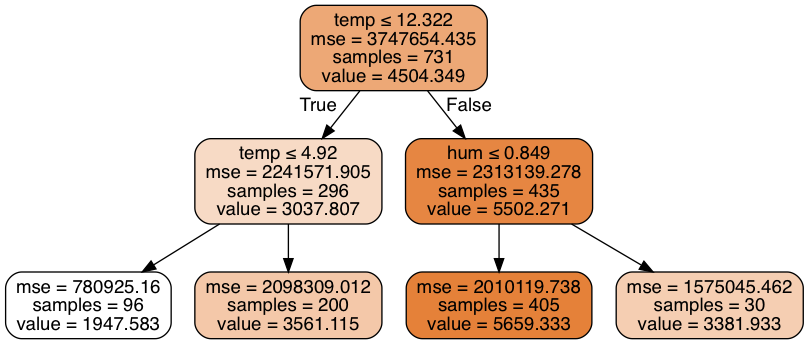

In [6]:
dot_data = StringIO()
tree.export_graphviz(dt, out_file=dot_data, 
                                feature_names=X.columns,
                                filled=True, rounded=True, 
                                special_characters=True) 

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Interpretation? 

* 4 Pfade im Baum, 4 Blätter, 3 Knoten (den ersten Knoten bezeichnet man als *root*)
* Pfad links: Wenn Temperatur <= 4.92 (Fh), ist die Vorhersage am niedrigsten (1948)
* Pfad rechts: Wenn Temperatur >= 12.322 und hohe Luftfeuchtigkeit (>= 0.849) ist die Vorhersage am höchsten (3382)
* samples: Anzahl an Trainingsdaten, welche in diesem Blatt landen
* value: Prognose von `cnt` für alle Datenpunkte in diesem Blatt
* `mse`: mean squared error Wert auf den Trainingsdaten

In [1]:
import seaborn as sns
sns.set(color_codes=True)
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.5)

import matplotlib as mpl
import matplotlib.pyplot as plt

font = {'family' : 'serif',
        'size'   : 28}

mpl.rc('font', **font)
mpl.style.use('seaborn')

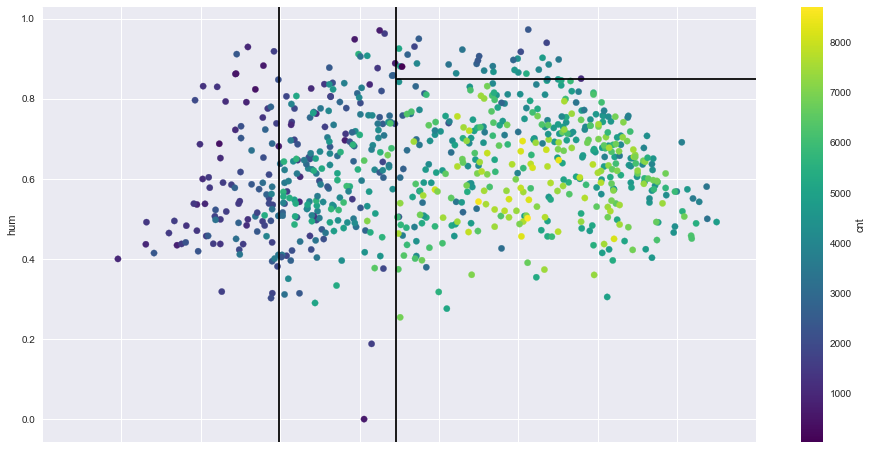

In [35]:
ax2 = df_reduced.plot.scatter(x='temp',y='hum',c='cnt',colormap='viridis', s=40, figsize=(16,8), 
                              xlim=(-10,35))
ax2.axvline(12.322, color='black'); ax2.axvline(4.92, color='black')
x2, y2 = [12.322, 35], [0.849,0.849]
plt.plot(x2, y2, color='black');
plt.savefig('dec_tree_scatter.png')

#### Wie gut/schlecht sind die Vorgersagen durch diesen Algorithmus?

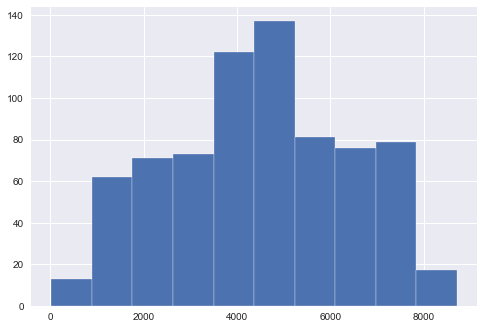

In [11]:
df_reduced['cnt'].hist();

In [12]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_reduced['cnt'].values, (df_reduced['cnt'] + 1000).values)

1000000.0

Wenn die Prognose pro Datenpunkt um 1000 nach oben abweichen würde, wäre der `mse` geringer als die vom trainierten Entschiedungsbaum erreichten Werte in 3 von 4 Blättern. 

## Entscheidungsbaum: Algorithmus

* **Schritt 1 (Teil des Trainings)**: Teile den Prädiktor-Raum in $k$ **sich nicht-überschneidende '$p$-dimensionale Rechtecke'** ein: $R_1, \ldots , R_k$ ($p$ ist die Anzahl an Prädiktoren) 
* **Schritt 2 (Anwendung)**: Jeder Datensatz, welcher in Region $R_j$ landet, erhält die gleiche Prognose, und zwar den **Mittelwert** der Zielvariable von allen zu $R_j$ zugehörigen Trainingsdaten 
* Beispiel: zwei Regionen, $R_1$ und $R_2$. Trainingsdaten in $R_1$ hatten im Durchschnitt 4500 Ausleihen, in $R_2$ waren es 2700. Falls ein neuer Datenpunkt in $R_1$ landet, prognostiziere 4500 Ausleihen, sonst 2700. 

<figure>
    <img src="images/dec_tree_scatter.png" alt="Drawing" style="width: 800px;"/> 
    <br>
</figure>

## Training (Regressionsbaum)

**Ziel**: Finde Rechtecke / Boxen $R_1, \ldots , R_k$, so dass der Fehler **RSS minimiert wird**:

$$ \sum_{j=1} ^k \sum_{R_j} (y_i - \hat{y}_{R_j})^2$$

* $\hat{y}_{R_j}$ ist der Mittelwert der Werte der Zielvariable für alle Trainingsdaten in $R_j$
* Innere Summe: Summe der quadratischen Fehler für alle Trainingsdaten in Rechteck $R_j$
* Äußere Summe: Summe über alle Rechtecke
* `RSS`: **residual sum of squares**, quasi nicht-normierter `MSE`

**Problem**: es ist rechnerisch nicht möglich, jede mögliche Aufsplittung des Raums in Rechtecke zu betrachten

**Lösung**: Recursive binary splitting: top-down greedy approach

* **top-down**: startet ganz oben an der Baum-Spitze, wo noch alle Daten in einem Rechteck liegen, und teilt den Prädiktor-Raum sukzessive auf. 
* **greeedy**: Auf jeder Stufe des Baumes wird der optimale Split gemacht ohne vorauszuschauen, welchen Effekt weitere Schritte haben würden.


### Training

1. Berechne den Wert von `RSS` auf dem gesamten Trainigsdatensatz

2. **Finde diejenige Variable $X_j$ und Schwellwert $s$, so dass die Aufteilung der Trainigsdaten in**

**$${x = (x_1, \ldots , x_p): x_j < s} \quad\text{und}\quad {x = (x_1, \ldots , x_p): x_j >= s}$$**

**den initialen `RSS` Wert am meisten reduziert**

3. **Wiederhole** das Verfahren für die in Schritt 2. erzeugten Regionen und zugehörigen Trainingsdaten

4. Dieser Prozess wird so lange fortgesetzt, bis ein vorher definiertes **Stop-Kriterium** (z.B. maximale Baumtiefe) erreicht worden ist

5. Berechne pro Blatt den durchschnittlichen Wert der Zielvariable für alle Trainingsdaten im Blatt

### Anwendung

Leite den neuen Datenpunkt durch den Baum zum zugehörigen Blatt und weise den Prognosewert zu

## Hyperparameter

Welche können Sie sich vorstellen?

* maximale Baumtiefe
* Mindestanzahl an Daten pro Blatt
* Mindestanzahl an Daten pro Knoten
* ... es gibt einige, und manche sind redundant

## Wie schätzen Sie das Potenzial zum Overfitting ein?

In [16]:
from sklearn.model_selection import train_test_split

In [22]:
dt = DecisionTreeRegressor(max_depth=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
dt.fit(X_train, y_train)
dt.score(X_train, y_train)

0.4961599962864274

In [32]:
dt = DecisionTreeRegressor(max_depth=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
dt.fit(X_train, y_train)
dt.score(X_train, y_train)

1.0

Wenn wir maximale Baumtiefe =20 erlauben, bekommen wir ein perfektes Modell auf den Trainingsdaten, mit nur 2 Prädiktor-Variablen!

In [33]:
dt.score(X_test, y_test)

0.2731065791535864

Das Modell performt sehr schlecht auf Testdaten, d.h. schlechte Generalisierbarkeit durch Over-Fitting


## Regularisierung

* Bekannteste Strategie ist **Pruning**
* Idee: Schneide den Entscheidungsbaum auf einen Teilbaum zurück (d.h. entferne manche Knoten), so dass dieser einen möglichst geringen Cross validation Fehler auf der Testmenge liefert
* D.h. Auswertung auf einer Testmenge ist Teil der Regularisierung
* Leider nicht in `sklearn` implementiert

# Entschiedungsbäume für Klassifikation

Welcher Teil des Algorithmus für Regression lässt sich übertragen? Was muss neu konzipiert werden?

* Finale Entscheidung: Mehrheitsvorum statt Mittelwert (wie bei $k$-NN)
* Zu minimierende Fehlerart: `RSS` eignet sich nicht. 
* Minimiere Anzahl an Datenpunkten, die nicht zur Mehrheitsklasse im jeweiligen Rechteck gehören? Eignet sich leider nicht gut...
* Alternativen: **Gini-Index** und **Entropie**. Für beide ist der Wert klein, wenn die **Datenpunkte in einem Knoten überwiegend zu genau einer Klasse gehören**

# Kategorische Variablen

* Entschiedungsbäume als Verfahren eignen sich auch für kategorische Variablen
* leider ist für Anwendung in `sklearn` Umwandlung in Boolsche Dummy-Variablen nötig 
* Achtung: Gruppierung von Datenpunkten teilweise notwendig, um sog. *long tail problem* (viele seltene Werte führen zu vielen zusätzlichen Features) zu vermeiden

# Vor- und Nachteile von Entscheidungsbäumen


* (+) Einfach zu erklären; sogar einfacher als lineare Regressionsmodelle
* (+) Es gibt die Ansicht, dass unter den meisten ML Verfahren, Entscheidungsbäume am besten die Entscheidungsfindung von Menschen wiedergeben
* (+) Bäume können visualisiert und selbst von nicht-Experten interpretiert werden (außer sie sind zu groß)
* (+) Bäume können (eigentlich) mit kategorischen Variablen umgehen

* (-) Entschiedungsbäume performen häufig schlechter als alternative Verfahren
* (-) Entschiedungsbäume sind nicht sehr robust, d.h. kleine Änderungen in Daten können zu deutlich anderen Bäumen führen 

# Ensembles von Entscheidungsbäumen

* statt einen einzelnen Baum trainieren wir mehrere Bäume und kombinieren diese
* verschiedene Verfahren: Bagging, Boosting, Random Forests
* Ziel: robustere Modelle, welche die Varianz reduzieren

## Bagging

* Entschiedungsbäume zeigen hohe Varianz, d.h. würden wir die Trainingsmenge in zwei Teile teilen und auf beiden jeweils ein Modell trainieren, würden wir vermutlich sehr unterschiedliche Modelle bekommen (siehe Bulls Eye Darstellung zu Bias & Variance)
* Idee: wir tun genau das und kombinieren die Ergebnisse
* **Erzeuge $n$ Trainigsmengen $T_i$ gleicher Größe durch zufälliges Ziehen mit Zurücklegen aus der ursprünglichen Trainingsmenge** ($n$ *bootstrapped training sets*); trainiere $n$ verschiedene Bäume und kombiniere ihre Ergebnisse 
* **Zusätzlicher Hyperparameter: $n$: Anzahl an Bäumen bzw. Bootstraps**

## Out-Of-Bag (OOB) estimates

* man kann zeigen, dass jeder neue Trainingssatz $T_i$ ca. 1/3 der Trainingsdaten auslässt
* ein Datensatz, welcher in der Trainingsmenge für eine 'bagged tree' nicht vorkommt, heißt **out-of-bag**
* Dies ermöglicht die Berechnung eines **validen Test-Scores** ohne weitere Aufteilung der Daten: für jeden Datenpunkt $x$ betrachte alle 'bagged trees', für die $x$ OOB ist. Berechne die Vorhersage für $x$ nur mit Hilfe dieser Bäume.

## Welchen Nachteil bringt Bagging mit sich, den wir bei Entscheidungsbäumen hatten?

Generalisierbarkeit verbessert sich **auf Kosten von Interpretierbarkeit**, insbesondere wenn viele Bäume verwendet werden.

Es lässt sich jedoch eine zusammenfassende Beschreibung der Relevanz der einzelnen Features generieren: **Feature Relevance** oder auch **Variable Importance** genannt

<figure>
    <img src="images/random-forest.jpg" alt="Drawing" style="width: 600px;"/> 
    <br>
</figure>

* Verbesserung gegenüber Bagging
* Bäume werden ebenfalls mit Hilfe von 'bagged training sets' trainiert
* Unterschied: bei jedem Split wird nur eine zufällig ausgewählte Teilmenge an Prädiktoren berücksichtigt
* Die Teilmenge von zu berücksichtigenden Prädiktoren wird für jeden Split neu erstellt
* Anzahl an Prädiktoren $m$ pro Split typischerweise $m \sim \sqrt{p}$
* **Zusätzlicher Hyperparameter: $m$: Anzahl an Prädiktoren pro Split**

Der Großteil der Prödiktoren wird bei jedem Split ignoriert! Warum könnte das trotzdem sinnvoll sein?

### Beispiel 

ein Prädiktor $x_j$ besonders wichtig und einige andere nur moderat wichtig. 

$\Rightarrow$ Beim Bagging würden die meisten Bäume beim obersten Split den Prädiktor $x_j$ verwenden

$\Rightarrow$ Die Bäume würden sich ähneln, Vorhersagen der verschiedenen Bäume wären stark korreliert

$\Rightarrow$ Keine hohe Reduktion der Varianz

Bei RF würden ca. $\frac{p-m}{p}$ den starken Prädiktor $x_j$ gar nicht verwenden, andere hätten dann eine Chance ins Gewicht zu fallen

Weiterführende Literatur: *G. James, D. Witten,  T. Hastie and R. Tibshirani*, An Introduction to Statistical Learning, with applications in R (2013).

# Hyperparameter Tuning

Machine Learning Modelle verfügen in der Regel über zwei verschiedene Arten von Parametern:

* Modellparameter: werden in der Trainingsphase gelernt (z.B. Gewichte bei linearer Regression)
* Hyperparameter: werden vor dem Training festgelegt (z.B. $k$ bei $k$-NN)

* Wir kennen nun ein paar Verfahren mit Hyperparametern ($k$-NN, Ridge, Lasso, Logistische Regression, SVC, Decision Tree, Random Forest)
* Wie wählen wir die Hyperparameter aus?
* Kennen bereits zwei Verfahren, um die **Generalisierbarkeit** eines Modells zu bewerten: Train-Test-Split und $K$-fold Cross Validation

Um optimale Hyperparameter auszuwählen, und gleichzeitig eine realistische Bewertung der Generalisierbarkeit eines Modells zu bekommen, benötigen wir eine weitere Teilmenge, das sog. **Validation Set** (eine Art Testmenge für das 'Training' der Hyperparameter):

### Training, validation, test 
------
<figure>
    <img src="images/train_validation_test.png" alt="Drawing" style="width: 750px;"/> 
    <br>
</figure>


* Validation Set: für die Auswahl der besten Hyper-Parameter
* Test set: Evaluation der Generalisierbarkeit des finalen Algorithmus    

## Grid Search

* definiere relevante Parameter-Kombinationen (Parameter-Gitter)
* Probiere alle Konbinationen durch und wähle mit Hilfe des Validation Sets die beste aus
* Implementiert intern eine $K$-Fold Cross Validation

<figure>
    <img src="images/cross_validation.png" alt="Drawing" style="width: 750px;"/> 
    <br>
</figure>

<figure>
    <img src="images/grid_search.png" alt="Drawing" style="width: 750px;"/> 
    <br>
</figure>